# Text Classification on user complaints with W&B Tables and Artifacts

# Evaluating the performance on best model

Once the hyperparameter tuning has been executed, we perform some evaluation tasks to gain some insights about the performance.

### Importing the libraries

First, we need to download the wandb library

In [1]:
!pip install wandb -qqq
!pip install scikit-plot
!pip install seaborn

In [2]:
!pip install keras tensorflow

In [3]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from numpy.random import seed

from pathlib import Path

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import set_random_seed

import tensorflow as tf

from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

2023-10-08 17:33:41.497279: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 17:33:42.347392: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 17:33:42.352588: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 17:33:45.030590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# Import the seaborn library, it is a powerful library for plotting and commonly used with matplotlib
import seaborn as sns
sns.set_style("white")

In [5]:
import params

We are setting seed for reproducibility

In [6]:
# To reproduce the experiment
s=42
# Set the seed for reproducibility
set_random_seed(s)

## Helper functions

In [7]:
def download_data():
    # Define the artifact to use
    processed_data_at = run.use_artifact(f'{params.PROCESSED_DATA_AT}:latest', type='split_data')
    # Download the data in the artifact
    processed_dataset_dir = Path(processed_data_at.download())
    return processed_dataset_dir

def get_target_dict(df):
    # Extract the unique category values
    target_classes = df['product'].unique()
    # Create a dictionary
    target_values = dict(zip(target_classes, range(5)))

    return target_values, target_classes

def get_datasets(processed_dataset_dir):
    # Read the data from the artifact as a csv file
    df = pd.read_csv(processed_dataset_dir / params.SPLIT_FILENAME)
    # GEt target values
    target_values, target_classes = get_target_dict(df)
    # Replace values in column product with integer values using the dict
    df.replace({'product': target_values}, inplace=True)
    # Create the train dataset
    X_train= df[df['stage']=='train']['narrative'].values
    y_train= df[df['stage']=='train']['product'].values
    # Create the validation dataset
    X_val= df[df['stage']=='validation']['narrative'].values
    y_val= df[df['stage']=='validation']['product'].values
    # Create the validation dataset
    X_test= df[df['stage']=='test']['narrative'].values
    y_test= df[df['stage']=='test']['product'].values

    return X_train, y_train, X_val, y_val, X_test, y_test, target_values, target_classes

def tokenize_text(X_train,X_val,X_test,max_tokens, tokenizer):
    # Adjust the tokenizer
    tokenizer.fit_on_texts(np.concatenate([X_train,X_val]))

    ## Vectorizing data to keep max_tokens words per sample.
    X_train_vect = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_tokens, padding="post", truncating="post", value=0.)
    X_val_vect  = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_tokens, padding="post", truncating="post", value=0.)
    X_test_vect  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_tokens, padding="post", truncating="post", value=0.)

    return X_train_vect, X_val_vect, X_test_vect

def evaluate_model(model, X_val, X_val_vect, y_val, target_classes,log_preds):
    val_preds = model.predict(X_val_vect)
    # Create the classification report
    report = classification_report(y_val, np.argmax(val_preds, axis=1), target_names=target_classes, output_dict=True)
    # Create a df with the report
    df_report = pd.DataFrame(report).transpose()
    df_report.reset_index(inplace=True)
    df_report = df_report.rename(columns = {'index':'category'})
    # Draw the confussion matrix for the test dataset
    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in y_val], [target_classes[i] for i in np.argmax(val_preds, axis=1)],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Blues",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        );
    plt.xticks(rotation=90)
    plt.savefig('confussion_matrix.png')

    if log_preds:
        val_prediction= pd.Series(np.argmax(val_preds, axis=1))
        df_val= pd.concat([pd.Series(X_val), pd.Series(X_val_vect.tolist()), pd.Series(y_val), pd.Series(target_classes[y_val]), pd.DataFrame(val_preds), 
                           val_prediction, pd.Series(target_classes[val_prediction])], axis=1)
        df_val.columns = ['complaint','complaint_tokens', 'product','product_class','prob0','prob1','prob2','prob3','prob4','prediction','prediction_class']

    return df_report, df_val, 'confussion_matrix.png'


## Download the data from W&B Artifacts

Download the data from the Artifact we save previously, we will use W&B Artifacts to track the lineage of our models.

In [15]:
"""
WANDB_PROJECT = "consumer_complaints_classification"
ENTITY = None # set this to team name if working in a team
RAW_DATA_AT = 'consumer_complaints_eda'
PROCESSED_DATA_AT = 'consumer_complaints_split'
SPLIT_FILENAME = 'consumer_complaints_split.csv'
BASELINE_DATA_AT = 'consumer_complaints_baseline'
"""

In [47]:
# Init the wandb session in our project
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="evaluation")
# Define the artifact to use
processed_data_at = run.use_artifact(f'{params.PROCESSED_DATA_AT}:latest', type='split_data')
# Download the data in the artifact
processed_dataset_dir = Path(processed_data_at.download())

wandb: Downloading large artifact consumer_complaints_split:latest, 98.06MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.4


In [9]:
processed_dataset_dir

PosixPath('artifacts/consumer_complaints_split:v0')

## Download the best model

In [10]:
# Get the artifact containing the best model
artifact = run.use_artifact('edumunozsala/model-registry/User Complaints Text Classifier:v1', type='model')
artifact_dir = Path(artifact.download())

wandb: Downloading large artifact User Complaints Text Classifier:v1, 54.43MB. 5 files... 
wandb:   5 of 5 files downloaded.  
Done. 0:0:0.7


In [11]:
artifact_dir

PosixPath('artifacts/run_ykz9r8iq_model:v7')

### Get the configuration of the model to evaluate

In [12]:
producer_run = artifact.logged_by()
wandb.config.update(producer_run.config)
config = wandb.config

In [13]:
print(config)

{'lr': 0.00041224613475931336, 'seed': 42, 'epochs': 8, 'dropout': 0.3, 'framework': 'keras', 'log_preds': True, 'batch_size': 256, 'cnn_layers': 1, 'max_tokens': 128, 'pretrained': False, 'filter_size': 7, 'kernel_size': 64, 'num_classes': 5, 'weight_decay': 0.9430068991225528, 'embedding_size': 128}


### Define the dataset 

In [14]:
# Download the data in the artifact
processed_dataset_dir = download_data()
# Split the datasets
X_train, y_train, X_val, y_val, X_test, y_test, target_values, target_classes = get_datasets(processed_dataset_dir)
# Create the tokenizer
tokenizer = Tokenizer()
# Tokenize the texts
X_train_vect, X_val_vect, X_test_vect = tokenize_text(X_train,X_val,X_test, config.max_tokens, tokenizer)

wandb: Downloading large artifact consumer_complaints_split:latest, 98.06MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.3


We create our train and validation dataset, defining the array of features and the array of label for every dataset

In [15]:
print('Train dataset size: ',X_train.shape, ' Validation dataset size: ',X_val.shape, ' Test dataset size: ',X_test.shape)
print('Target classes: ', target_classes)

Train dataset size:  (51416,)  Validation dataset size:  (11018,)  Test dataset size:  (11018,)
Target classes:  ['credit_card' 'debt_collection' 'credit_reporting' 'retail_banking'
 'mortgages_and_loans']


## Create the model from our registered model 

In [16]:
# Restore the best model
model = tf.keras.models.load_model(artifact_dir)
# Show the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          4689664   
                                                                 
 conv1d (Conv1D)             (None, 128, 64)           57408     
                                                                 
 tf.math.reduce_max (TFOpLa  (None, 64)                0         
 mbda)                                                           
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 4747397 (18.11 MB)
Trainable params: 4747397 (18.11 MB)
Non-trainable params: 0 (0.00 Byte)
_____________________

### Evaluate the registered model 

We evaluate the registered model on the same validation dataset and compare the metrics with the ones we obtained in the fine-tuning run

345/345 [==============================] - 4s 13ms/step


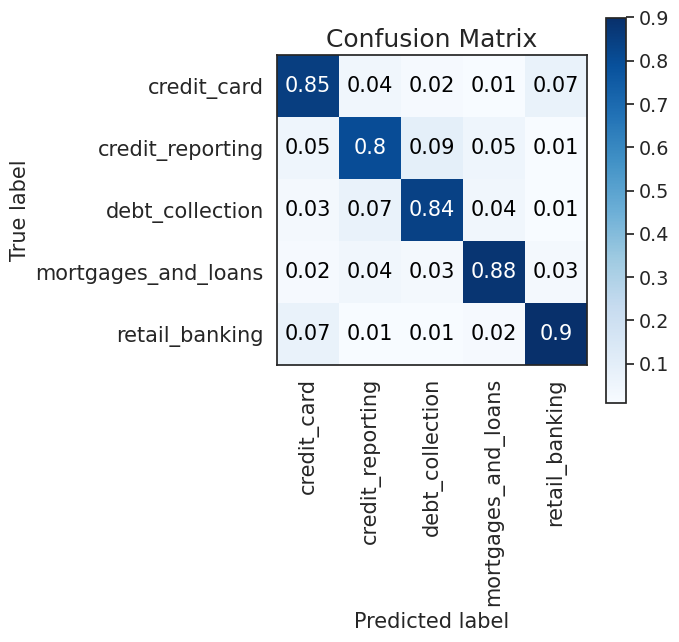

In [48]:
# Evaluate the model
df_report, df_val, conf_matrix = evaluate_model(model, X_val, X_val_vect, y_val, target_classes, config.log_preds)

In [18]:
df_val.head()

,complaint,complaint_tokens,product,product_class,prob0,prob1,prob2,prob3,prob4,prediction,prediction_class
0,already notified university improperly collect...,"[180, 356, 2028, 2849, 43, 122, 2, 753, 263, 6...",2,credit_reporting,0.000881,0.437974,0.557944,0.000297,0.002905,2,credit_reporting
1,first progress card give provisional credit di...,"[87, 1794, 5, 172, 1467, 2, 39, 152, 205, 767,...",0,credit_card,0.628951,0.015145,0.010382,0.344718,0.000803,0,credit_card
2,opened credit card account capital one capital...,"[110, 2, 5, 1, 148, 22, 148, 22, 4888, 68, 185...",0,credit_card,0.981875,0.010917,0.001731,0.001397,0.004080,0,credit_card
3,writing today regard account kia motor finance...,"[343, 151, 519, 1, 2314, 1858, 389, 49, 3, 250...",4,mortgages_and_loans,0.033089,0.003010,0.031989,0.000559,0.931353,4,mortgages_and_loans
4,duplicate complaint synchrony need step forwar...,"[1447, 57, 525, 61, 644, 571, 381, 55, 1118, 3...",0,credit_card,0.990708,0.001780,0.004489,0.001131,0.001893,0,credit_card


Lets visualize the classification report for our registered model

In [19]:
display(df_report)

,category,precision,recall,f1-score,support
0,credit_card,0.835460,0.845127,0.840265,2247.000000
1,debt_collection,0.846017,0.844889,0.845453,2250.000000
2,credit_reporting,0.831863,0.796000,0.813536,2250.000000
3,retail_banking,0.873917,0.898565,0.886070,2021.000000
4,mortgages_and_loans,0.878253,0.884889,0.881559,2250.000000
5,accuracy,0.852968,0.852968,0.852968,0.852968
6,macro avg,0.853102,0.853894,0.853377,11018.000000
7,weighted avg,0.852674,0.852968,0.852701,11018.000000


### Download the Classification Report from the artifacts in the fine-tuning run

In [20]:
producer_run.summary['epoch/val_accuracy']

0.8529678583145142

In [21]:
import json
#type(producer_run.logged_artifacts())
assert producer_run.logged_artifacts()[8].name == 'consumer_complaints_hptuning:v45'
print('Captured logged artifact')
#['edumunozsala/consumer_complaints_classification/consumer_complaints_hptuning:v45', type='tuning')
# Download the artifact
table_dir = producer_run.logged_artifacts()[8].download()

Captured logged artifact


wandb:   3 of 3 files downloaded.  


In [22]:
# Read the Table
table_name = "classification_report"
table_path = f"{table_dir}/{table_name}.table.json"
print(table_path)
with open(table_path) as file:
    json_dict = json.load(file)

#Create a Dataframe from the Table artifact
df = pd.DataFrame(json_dict["data"], columns=json_dict["columns"])
display(df)

./artifacts/consumer_complaints_hptuning:v45/classification_report.table.json


,category,precision,recall,f1-score,support
0,credit_card,0.835460,0.845127,0.840265,2247.000000
1,debt_collection,0.846017,0.844889,0.845453,2250.000000
2,credit_reporting,0.831863,0.796000,0.813536,2250.000000
3,retail_banking,0.873917,0.898565,0.886070,2021.000000
4,mortgages_and_loans,0.878253,0.884889,0.881559,2250.000000
5,accuracy,0.852968,0.852968,0.852968,0.852968
6,macro avg,0.853102,0.853894,0.853377,11018.000000
7,weighted avg,0.852674,0.852968,0.852701,11018.000000


We can observe that both tables are exactly the same. **We can confirm that our registred model is the right one.**

## Error Analysis

when evaluating the performance of our selected model, we should spend some time reviews the errors and try to identified "pain" points, or common features in those errors, etc. this excelelent exercise will give us some insights about our data and how to improve the model performance. 

In [19]:
df_error = df_val[df_val['product']!=df_val['prediction']]

In [49]:
df_error['product'].value_counts(),df_val['product'].value_counts()

(product
 2    459
 1    349
 0    348
 4    259
 3    205
 Name: count, dtype: int64,
 product
 2    2250
 4    2250
 1    2250
 0    2247
 3    2021
 Name: count, dtype: int64)

We inspect if there is any class that is more likely to get wrong predictions. The product category 2 or credit_reporting 

In [50]:
df_error

,complaint,complaint_tokens,product,product_class,prob0,prob1,prob2,prob3,prob4,prediction,prediction_class
9,account reported valid credit card referring p...,"[1, 94, 524, 2, 5, 2264, 368, 34, 1, 966, 872,...",2,credit_reporting,0.248371,0.593296,0.121129,0.022266,0.014938,1,debt_collection
12,account fraudulent activity requested froward ...,"[1, 100, 366, 97, 20623, 120, 222, 1951, 62, 4...",2,credit_reporting,0.001837,0.898459,0.095300,0.000299,0.004105,1,debt_collection
17,violation fcra law failed provide correct debt...,"[205, 322, 141, 326, 84, 213, 16, 390, 10, 186...",2,credit_reporting,0.011393,0.904286,0.073713,0.000665,0.009943,1,debt_collection
24,applied sunoco fleet credit card used name ein...,"[210, 13928, 8105, 2, 5, 139, 69, 3636, 27, 19...",2,credit_reporting,0.617834,0.018453,0.345652,0.015071,0.002989,0,credit_card
25,accident occur home destroyed homeowner insura...,"[1621, 1634, 88, 2056, 886, 158, 1520, 71, 324...",3,retail_banking,0.117921,0.134058,0.291629,0.056049,0.400343,4,mortgages_and_loans
...,...,...,...,...,...,...,...,...,...,...,...
11001,one late payment month ago tried calling speak...,"[22, 49, 3, 25, 307, 107, 289, 282, 138, 1601,...",4,mortgages_and_loans,0.449964,0.034579,0.195839,0.007766,0.311853,0,credit_card
11011,spoken shellpoint reporting credit report mort...,"[873, 689, 42, 2, 8, 35, 9, 2818, 2, 8, 50, 16...",4,mortgages_and_loans,0.000971,0.297066,0.600485,0.000080,0.101398,2,credit_reporting
11012,filed dispute transaction amount debit card pu...,"[152, 39, 66, 28, 291, 5, 132, 31, 102, 25, 30...",3,retail_banking,0.693166,0.007335,0.005283,0.292348,0.001868,0,credit_card
11015,account set auto payment paid minimum balance ...,"[1, 352, 404, 3, 37, 567, 32, 1, 108, 1, 250, ...",0,credit_card,0.178336,0.057742,0.705101,0.008934,0.049887,2,credit_reporting


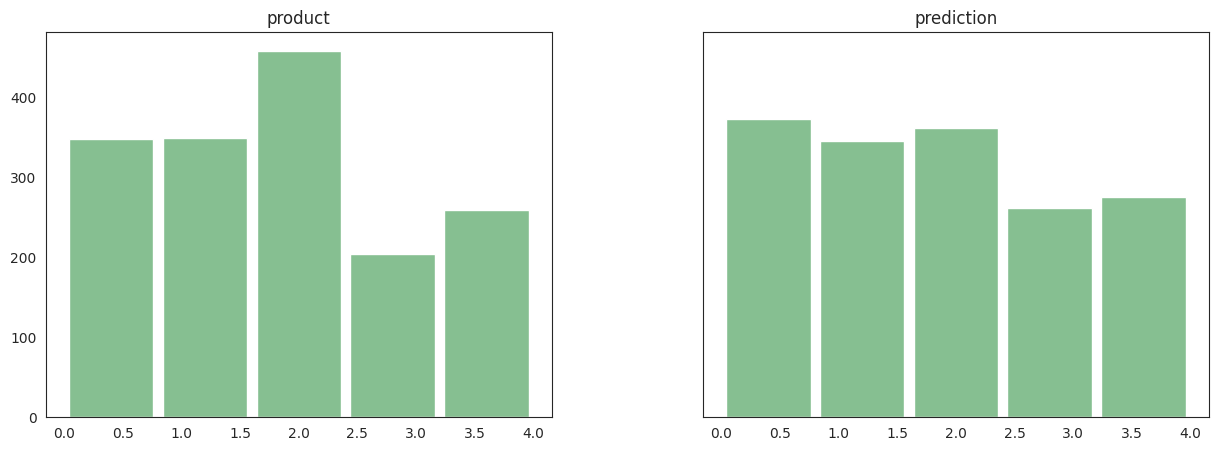

In [48]:
fig = df_error.hist(column=["product","prediction"],bins=5, grid=False, figsize=(15,5), layout=(1,2), sharey=True, 
              color='#86bf91', zorder=2, rwidth=0.9)

plt.savefig('error_product_classes.png')
#fig[0,1].savefig('error_prediction_classes.png')

Create a new dataframe only containing the errors

In [22]:
df_error_2 = df_error[df_error['product']==2]

In [23]:
df_error_2[df_error['prob2']<0.5]

/tmp/ipykernel_90/1983591165.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_error_2[df_error['prob2']<0.5]


,complaint,complaint_tokens,product,product_class,prob0,prob1,prob2,prob3,prob4,prediction,prediction_class
9,account reported valid credit card referring p...,"[1, 94, 524, 2, 5, 2264, 368, 34, 1, 966, 872,...",2,credit_reporting,0.248371,0.593296,0.121129,0.022266,0.014938,1,debt_collection
12,account fraudulent activity requested froward ...,"[1, 100, 366, 97, 20623, 120, 222, 1951, 62, 4...",2,credit_reporting,0.001837,0.898459,0.095300,0.000299,0.004105,1,debt_collection
17,violation fcra law failed provide correct debt...,"[205, 322, 141, 326, 84, 213, 16, 390, 10, 186...",2,credit_reporting,0.011393,0.904286,0.073713,0.000665,0.009943,1,debt_collection
24,applied sunoco fleet credit card used name ein...,"[210, 13928, 8105, 2, 5, 139, 69, 3636, 27, 19...",2,credit_reporting,0.617834,0.018453,0.345652,0.015071,0.002989,0,credit_card
85,believe may influenced submission office congr...,"[236, 186, 7364, 2256, 202, 5741, 3184, 182, 6...",2,credit_reporting,0.964413,0.007649,0.017001,0.010485,0.000452,0,credit_card
...,...,...,...,...,...,...,...,...,...,...,...
10839,identity theft told happened everything done o...,"[137, 176, 13, 360, 374, 183, 108, 379, 245, 5...",2,credit_reporting,0.552305,0.125482,0.236932,0.004272,0.081009,0,credit_card
10884,disputed account collection agency along origi...,"[181, 1, 43, 76, 533, 130, 1, 675, 2, 8, 94, 1...",2,credit_reporting,0.002175,0.678562,0.314919,0.001010,0.003334,1,debt_collection
10929,account great american finance paid full howev...,"[1, 921, 387, 389, 37, 116, 118, 921, 387, 389...",2,credit_reporting,0.040063,0.470026,0.197846,0.002059,0.290006,1,debt_collection
10944,account kia finance lease car bought time acco...,"[1, 2314, 389, 537, 178, 836, 7, 1, 27, 466, 1...",2,credit_reporting,0.007052,0.010115,0.057949,0.000439,0.924444,4,mortgages_and_loans


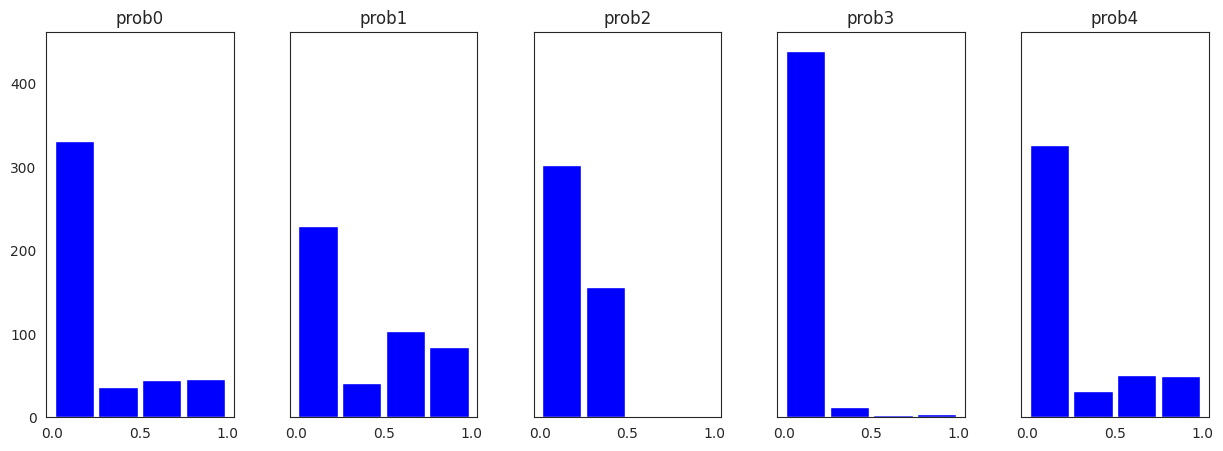

In [24]:
#df_error['prob4'].hist(bins=2)

#df_error.hist(column=["prob0","prob1","prob2","prob3","prob4"], bins=5)
df_error_2.hist(column=["prob0","prob1","prob2","prob3","prob4"],bins=[0,0.25,.5,0.75, 1], grid=False, figsize=(15,5), layout=(1,5), sharey=True, 
              color='blue', zorder=2, rwidth=0.9)
plt.savefig('error_product_class_2_probs.png')

The above figure shows us that many product classes 2 are predicted as product class 1, probably there many common words or very similar between these two classes.

In [25]:
df_error_1 = df_error_2[df_error_2['prob1']>0.5]

In [26]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
# Helper function
def plot_most_common_words(count_data, count_vectorizer, num_words, title):
    ''' Draw a barplot showing the tenth most common words in the data
        Input:
        - count_data: tuple, containing pairs of document-term and its ocurrencies in the text
        - count_vectorizer: CountVectorizer object
    '''
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:num_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 5))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    bplot = sns.barplot(x=x_pos, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    fig = bplot.get_figure()
    fig.savefig(title, format='png', bbox_inches='tight')
    plt.show()
    #plt.savefig(title)



In [52]:
# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(df_error_2['complaint'])
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
print(doc_term_matrix)

     able  account  accurate  act  action  added  address  advised  agency  \
0       0        3         0    0       0      0        0        0       0   
1       0        4         0    1       0      0        3        0       0   
2       2        6         0    0       0      0        0        0       3   
3       0        0         0    0       0      0        1        0       0   
4       0       17         0    0       0      0        3        0       0   
..    ...      ...       ...  ...     ...    ...      ...      ...     ...   
454     0        0         0    0       1      0        0        0       2   
455     0        4         0    0       0      0        0        0       1   
456     0        3         0    0       0      0        0        0       0   
457     0        6         0    0       0      0        0        0       0   
458     0        1         0    0       0      0        0        0       0   

     ago  ...  well  went  within  without  work  would  writin

/tmp/ipykernel_90/3047788105.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.barplot(x=x_pos, y=counts, palette='husl')


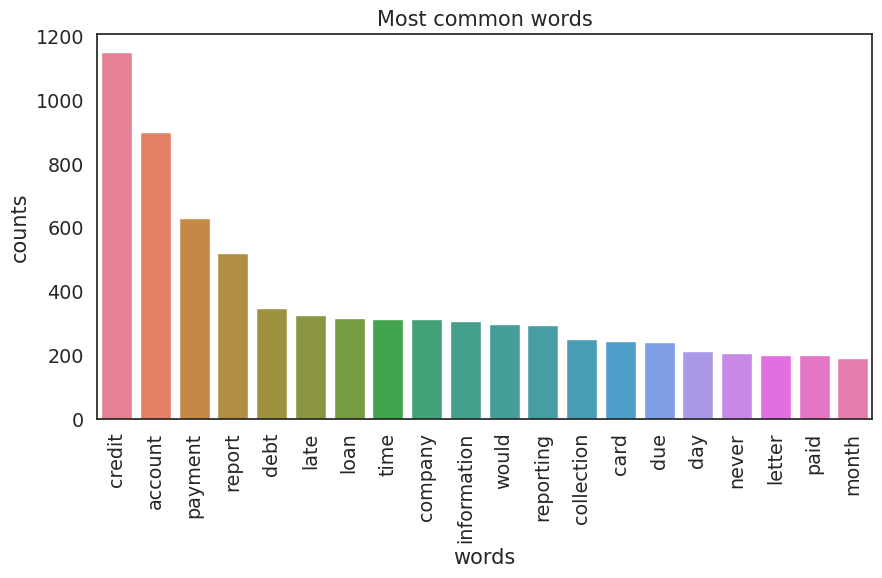

In [53]:
# Visualise the most common words
plot_most_common_words(tf, tf_vectorizer, 20, 'most_common_words_error_2.png')

Now lets visualize the common words for the class 2 error that has been predicted as class 1

In [54]:
# Initialise the count vectorizer
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
# Apply the count vectorized method to our cleaned data
tf = tf_vectorizer.fit_transform(df_error_1['complaint'])
# Build the Document Term Matrix
tf_feature_names = tf_vectorizer.get_feature_names_out()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
print(doc_term_matrix)

     account  act  address  agency  also  amount  balance  bill  bureau  \
0          3    0        0       0     0       0        0     0       0   
1          4    1        3       0     1       0        0     1       0   
2          6    0        0       3     0       2        0     0       0   
3          6    0        0       0     2       5        1     0       6   
4          0    0        0       0     0       0        0     1       0   
..       ...  ...      ...     ...   ...     ...      ...   ...     ...   
183        2    4        2       0     0       1        0     0       0   
184        1    0        0       0     0       0        0     0       0   
185        3    0        0       0     1       1        2     0       0   
186        4    0        0       1     0       0        0     0       0   
187        1    0        0       0     0       0        0     0       1   

     collect  ...  show  signature  state  still  time  validation  verified  \
0          1  ...  

/tmp/ipykernel_90/3047788105.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sns.barplot(x=x_pos, y=counts, palette='husl')


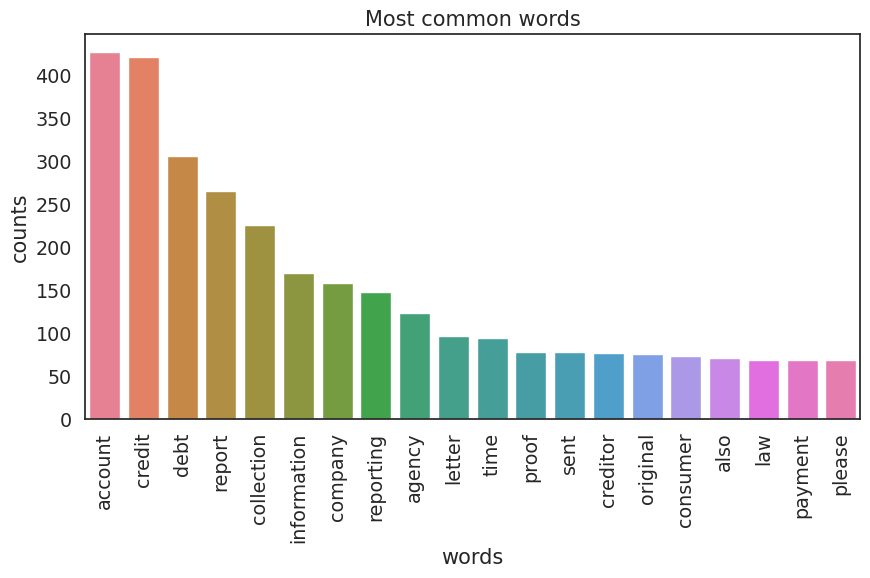

In [55]:
# Visualise the most common words
plot_most_common_words(tf, tf_vectorizer, 20, 'most_common_words_error_2_prob1.png')

### Save the evaluation results as an artifact in W&B

In [56]:
params.EVALUATION_DATA_AT

'consumer_complaints_evaluation'

In [57]:
#Create the artifact
evaluation_data_at = wandb.Artifact(params.EVALUATION_DATA_AT, type="evaluation")
# Add the classifation report
evaluation_data_at.add_file(conf_matrix)
# Save the classification report
report_table = wandb.Table(dataframe=df_report)
evaluation_data_at.add(report_table, "classification_report")
# Save evaluation data
evaluation_table = wandb.Table(dataframe=df_val)
evaluation_data_at.add(evaluation_table, "evaluation_table")
# Save prediction errors
error_table = wandb.Table(dataframe=df_error)
evaluation_data_at.add(error_table, "error_table")
# Save figure fro our error analysis
evaluation_data_at.add_file('error_product_classes.png')
evaluation_data_at.add_file('error_product_class_2_probs.png')
evaluation_data_at.add_file('most_common_words_error_2.png')
evaluation_data_at.add_file('most_common_words_error_2_prob1.png')

In [58]:
# Log artifacts
run.log_artifact(evaluation_data_at)
# Close connection
wandb.finish()

## Evaluate the model on the test dataset

Now, we evaluate the registered model on the test dataset to get the final performance of our model

345/345 [==============================] - 4s 11ms/step


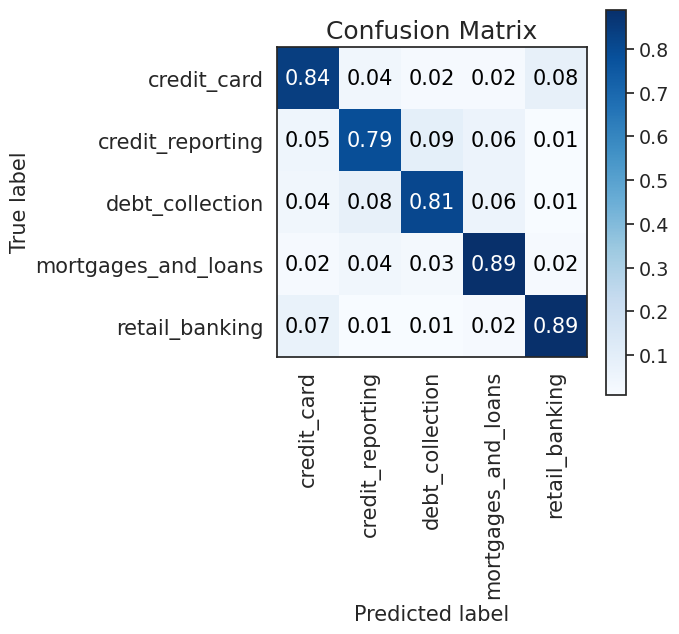

In [41]:
# Evaluate the model
df_report, df_val, conf_matrix = evaluate_model(model, X_test, X_test_vect, y_test, target_classes, config.log_preds)

In [79]:
display(df_report)
df_report['category']

,category,precision,recall,f1-score,support
0,credit_card,0.836509,0.839858,0.838180,2248.000000
1,debt_collection,0.838296,0.813333,0.825626,2250.000000
2,credit_reporting,0.826107,0.787556,0.806371,2250.000000
3,retail_banking,0.858377,0.885149,0.871557,2020.000000
4,mortgages_and_loans,0.849787,0.887556,0.868261,2250.000000
5,accuracy,0.841804,0.841804,0.841804,0.841804
6,macro avg,0.841815,0.842690,0.841999,11018.000000
7,weighted avg,0.841471,0.841804,0.841383,11018.000000


0            credit_card
1        debt_collection
2       credit_reporting
3         retail_banking
4    mortgages_and_loans
5               accuracy
6              macro avg
7           weighted avg
Name: category, dtype: object

**The accuracy reachs the value 0.8418 for the test dataset**.


In [77]:
params.TESTEVALUATION_DATA_AT

'consumer_complaints_test_evaluation'

### Save the evaluation results on the Test dataaset as an artifact in W&B

In [78]:
# Init the wandb session in our project
run = wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY, job_type="test_evaluation")


In [80]:
run.summary["test_accuracy"] = 0.841804

In [81]:
#Create the artifact
testevaluation_data_at = wandb.Artifact(params.TESTEVALUATION_DATA_AT, type="test_evaluation")
# Add the classifation report
testevaluation_data_at.add_file(conf_matrix)
# Save the classification report
report_table = wandb.Table(dataframe=df_report)
testevaluation_data_at.add(report_table, "classification_report")
# Save evaluation data
evaluation_table = wandb.Table(dataframe=df_val)
testevaluation_data_at.add(evaluation_table, "evaluation_table")

In [82]:
# Log artifacts
run.log_artifact(testevaluation_data_at)
# Close connection
wandb.finish()

test_accuracy,0.8418
